# Qura Question Pairs

## Importing some Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization,Embedding
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import nltk

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Downloading the dataset

In [3]:
!wget http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv

--2023-08-27 12:17:31--  http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv
Resolving qim.fs.quoracdn.net (qim.fs.quoracdn.net)... 162.159.153.247, 162.159.152.17
Connecting to qim.fs.quoracdn.net (qim.fs.quoracdn.net)|162.159.153.247|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://qim.fs.quoracdn.net/quora_duplicate_questions.tsv [following]
--2023-08-27 12:17:31--  https://qim.fs.quoracdn.net/quora_duplicate_questions.tsv
Connecting to qim.fs.quoracdn.net (qim.fs.quoracdn.net)|162.159.153.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58176133 (55M) [text/tab-separated-values]
Saving to: ‘quora_duplicate_questions.tsv’

quora_duplicate_que 100%[===================>]  55.48M   304MB/s    in 0.2s    

2023-08-27 12:17:31 (304 MB/s) - ‘quora_duplicate_questions.tsv’ saved [58176133/58176133]



In [4]:
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip

--2023-08-27 12:17:31--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip
Resolving huggingface.co (huggingface.co)... 13.33.33.20, 13.33.33.102, 13.33.33.55, ...
Connecting to huggingface.co (huggingface.co)|13.33.33.20|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/357baac33090f645e71e253b3295ee1b767c98a0336e9a1d99c77e9e33b43c4a?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27glove.42B.300d.zip%3B+filename%3D%22glove.42B.300d.zip%22%3B&response-content-type=application%2Fzip&Expires=1693397851&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5MzM5Nzg1MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9zdGFuZm9yZG5scC9nbG92ZS8zNTdiYWFjMzMwOTBmNjQ1ZTcxZTI1M2IzMjk1ZWUxYjc2N2M5OGEwMzM2ZTlhMWQ5OWM3N2U5ZTMzYjQzYzRhP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiZyZXNwb25zZS1jb250ZW50LXR5cGU9KiJ9XX0_&Signature=NiMUH%7EVOxNE6

### Loading the dataset

In [5]:
data=pd.read_csv('/content/quora_duplicate_questions.tsv',delimiter='\t')

## Importing some helper functions

In [6]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-27 12:19:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-27 12:19:24 (112 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [7]:
from helper_functions import unzip_data,walk_through_dir

In [8]:
unzip_data('/content/glove.42B.300d.zip')

## Exploring the dataset

In [9]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [10]:
data.tail()

,id,qid1,qid2,question1,question2,is_duplicate
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0
404289,404289,537932,537933,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


In [11]:
data['is_duplicate'].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [12]:
data.shape

(404290, 6)

In [13]:
data.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [14]:
data=data.dropna()

In [15]:
data.isna().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [16]:
question1=data['question1']
len_q1=[len(x.split()) for x in question1]

In [17]:
question2=data['question2']
len_q2=[len(x.split()) for x in question2]

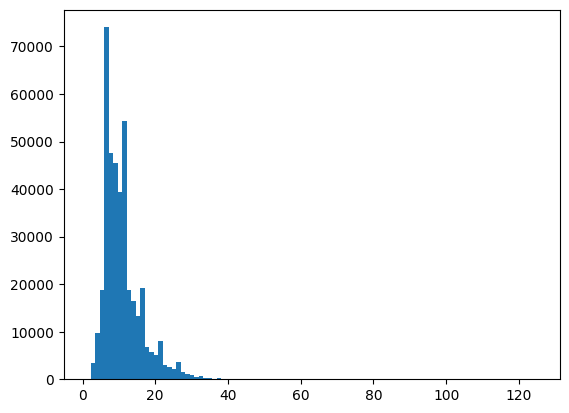

In [18]:
plt.hist(len_q1,bins=100);

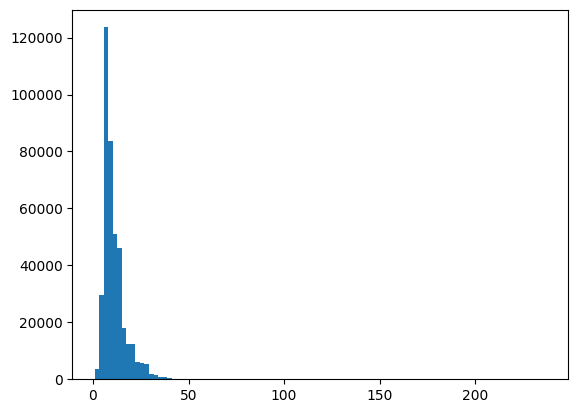

In [19]:
plt.hist(len_q2,bins=100);

In [20]:
max_len_q1=np.percentile(len_q1,99)
max_len_q1

29.0

In [21]:
max_len_q2=np.percentile(len_q2,99)
max_len_q2

33.0

## Data cleaning functions

In [22]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [23]:
stop_words = set(stopwords.words('english'))
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub("[^a-zA-Z]", " ", newString)
    return ' '.join(newString.split())

def remove_stopwords(text):
    tokens = [w for w in text.split() if not w in stop_words]
    return (" ".join(tokens)).strip()

In [24]:
text_cleaner("I'm a student at the University of Toronto.")

'i am a student at the university of toronto'

In [25]:
q1_sentences=data['question1'].apply(text_cleaner)

<ipython-input-23-8193ea76ea74>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  newString = BeautifulSoup(newString, "lxml").text


In [26]:
q2_sentences=data['question2'].apply(text_cleaner)

<ipython-input-23-8193ea76ea74>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  newString = BeautifulSoup(newString, "lxml").text


## Creating new dataframe

In [27]:
labels=data['is_duplicate']
cleaned_data=pd.DataFrame([q1_sentences,q2_sentences,labels]).transpose()

## Checking Average sentence length after cleaning

In [28]:
len_q1=[len(x.split()) for x in q1_sentences]
len_q2=[len(x.split()) for x in q2_sentences]

In [29]:
max_len_q2=int(np.percentile(len_q2,99))
max_len_q2

33

In [30]:
max_len_q1=int(np.percentile(len_q1,99))
max_len_q1=max_len_q2

In [31]:
max_len_q1

33

## Creating Char based Data

In [32]:
def split_chars(text):
  return ' '.join(list(text))

In [33]:
chars_q1=[split_chars(sentence) for sentence in q1_sentences]

In [34]:
chars_q2=[split_chars(sentence) for sentence in q2_sentences]

## Splitting dataset

In [35]:
cleaned_data['charq1']=chars_q1
cleaned_data['charq2']=chars_q2

In [36]:
from sklearn.model_selection import train_test_split
xtrain, xmid, ytrain, ymid = train_test_split(cleaned_data.drop('is_duplicate',axis=1),
                                                    cleaned_data['is_duplicate'],
                                                    test_size=0.15, random_state=42)
xval, xtest, yval, ytest = train_test_split(xmid,ymid,test_size=0.50, random_state=42)

# Preparing for Deep sequence modelling

In [ ]:
from tensorflow.keras.layers import TextVectorization,Embedding
import tensorflow as tf

## Character level tokenizer and embeddings

### Character level tokenizer

In [ ]:
char_len_q1=[len(sentence) for sentence in xtrain['question1']]
mean_char_len_q1=np.mean(char_len_q1)
mean_char_len_q1

57.60245370922731

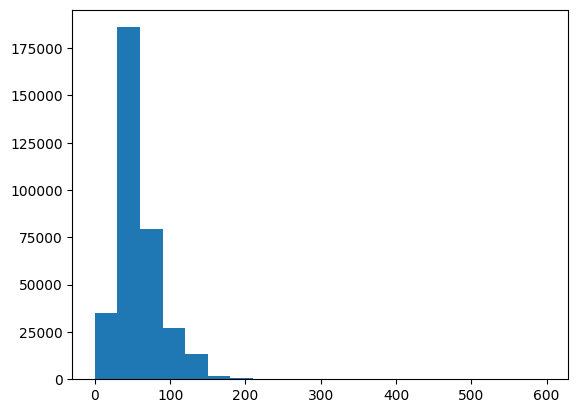

In [ ]:
# check distribution

import matplotlib.pyplot as plt

plt.hist(char_len_q1,bins=20);

In [ ]:
#find what character length covers 98% of sequences
output_seq_char_len_q1=int(np.percentile(char_len_q1,98))

In [ ]:
output_seq_char_len_q1

140

In [ ]:
char_len_q2=[len(sentence) for sentence in xtrain['question2']]
mean_char_len_q2=np.mean(char_len_q2)
mean_char_len_q2

58.12881391444028

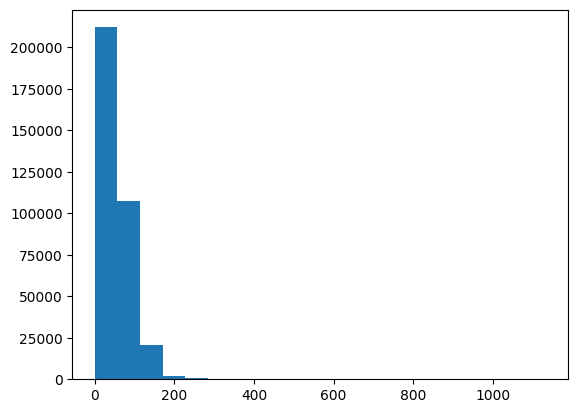

In [ ]:
# check distribution

import matplotlib.pyplot as plt

plt.hist(char_len_q2,bins=20);

In [ ]:
#find what character length covers 95% of sequences
output_seq_char_len_q2=int(np.percentile(char_len_q2,98))
output_seq_char_len_q2

144

In [ ]:
#number of alphanumeric characters
import string
alphabet=string.ascii_lowercase

In [ ]:
num_char_tokens_q1=len(alphabet) + 10 # add for space and UNK

In [ ]:
char_vectorizer=TextVectorization(max_tokens=num_char_tokens_q1,
                                  output_sequence_length=144,
                                  name='char_vectorizer')

In [ ]:
sentences=xtrain['charq1'].values.tolist()
char2_sentences=xtrain['charq2'].values.tolist()
sentences.extend(char2_sentences)

In [ ]:
char_vectorizer.adapt(sentences)

In [ ]:
#check character vocab stats
char_vocab=char_vectorizer.get_vocabulary()

### Character level Embedding

In [ ]:
output_dim=128
#input_dims=Vocab length
#mask_zero saves space by masking 0 values out with are padding
char_embedding=Embedding(input_dim=len(char_vocab),
                         output_dim=output_dim,
                         mask_zero=True,
                         name='char_embedding')

## Token Text Vectorization

In [ ]:
#Text vectorization layer
# Output_sequence_length= length of output sentence
max_tokens=160000
text_vectorizer=TextVectorization(max_tokens=max_tokens,
                                  split='whitespace',
                                  output_sequence_length=max_len_q1)

In [ ]:
sentences=xtrain['question1'].values.tolist()
q2_sentences=xtrain['question2'].values.tolist()
sentences.extend(q2_sentences)

In [ ]:
#Adapt text vectorizer to training sentences
text_vectorizer.adapt(sentences)

In [ ]:
vectorizer_vocab_token=text_vectorizer.get_vocabulary()

In [ ]:
len(vectorizer_vocab_token)

73990

## Token Embedding layer

In [ ]:
glove_file = 'glove.42B.300d.txt'
embeddings_index = {}
with open(glove_file, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
word_index = dict(zip(text_vectorizer.get_vocabulary(), range(len(text_vectorizer.get_vocabulary()))))

In [ ]:
# Create the embedding matrix
embedding_dim = 300
num_words = len(word_index)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [ ]:
output_dim=300
#input_dims=Vocab length
text_embedding=Embedding(input_dim=len(vectorizer_vocab_token),output_dim=output_dim,
                       embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                       trainable=False,name='token_embedding')

## Modelling

### Model1: Char Model:

#### Creating dataset

In [ ]:
train_char_data=tf.data.Dataset.from_tensor_slices((xtrain['charq1'].values,
                                               xtrain['charq2'].values))
train_char_labels=tf.data.Dataset.from_tensor_slices(ytrain.apply(pd.to_numeric).values)
train_char_dataset=tf.data.Dataset.zip((train_char_data,train_char_labels))
train_char_dataset=train_char_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)



val_char_data=tf.data.Dataset.from_tensor_slices((xval['charq1'].values,
                                             xval['charq2'].values))
val_char_labels=tf.data.Dataset.from_tensor_slices(yval.apply(pd.to_numeric).values)
val_char_dataset=tf.data.Dataset.zip((val_char_data,val_char_labels))
val_char_dataset=val_char_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)



test_char_data=tf.data.Dataset.from_tensor_slices((xtest['charq1'].values,
                                              xtest['charq2'].values))
test_char_labels=tf.data.Dataset.from_tensor_slices(ytest.apply(pd.to_numeric).values)
test_char_dataset=tf.data.Dataset.zip((test_char_data,test_char_labels))
test_char_dataset=test_char_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

#### Model

In [ ]:
q1_char_inputs=tf.keras.layers.Input(shape=(1,),dtype=tf.string)
q1_char_preprocessor=char_vectorizer(q1_char_inputs)
q1_char_embed=char_embedding(q1_char_preprocessor)


q2_char_inputs=tf.keras.layers.Input(shape=(1,),dtype=tf.string)
q2_char_preprocessor=char_vectorizer(q2_char_inputs)
q2_char_embed=char_embedding(q2_char_preprocessor)

char_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))
char_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))

q1_char_gru1=char_gru1(q1_char_embed)
q1_char_gru2=char_gru2(q1_char_gru1)


q2_char_gru1=char_gru1(q2_char_embed)
q2_char_gru2=char_gru2(q2_char_gru1)

q1_q2_char_concat=tf.keras.layers.Concatenate()([q1_char_gru2,
                                                  q2_char_gru2])

combined_char_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))(q1_q2_char_concat)
combined_char_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh',return_sequences=True))(combined_char_gru1)
combined_char_gru3=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh'))(combined_char_gru2)

output=tf.keras.layers.Dense(1,activation='sigmoid')(combined_char_gru3)

model1=tf.keras.Model(inputs=[q1_char_inputs,q2_char_inputs],
                      outputs=output,
                      name='Model1')

In [ ]:
model1.summary()

Model: "Model1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 144)         0           ['input_7[0][0]',                
 tion)                                                            'input_8[0][0]']                
                                                                                                  
 char_embedding (Embedding)     (None, 144, 128)     3584        ['char_vectorizer[0][0]',   

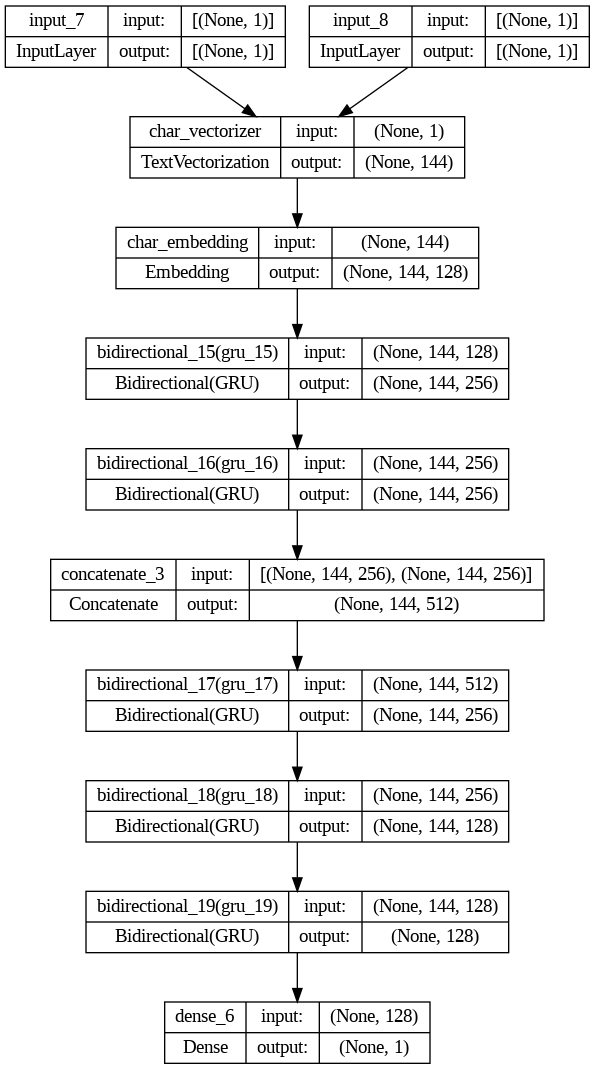

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model1,show_shapes=True)

In [ ]:
model1.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.Adam(lr=0.001),
               metrics=['accuracy'])

In [ ]:
# Early stopping
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print when the lr is reduced
                                                 min_lr=1e-7)

In [ ]:
history1=model1.fit(train_char_dataset,
                    epochs=10,
                    steps_per_epoch=int(0.2*len(train_char_dataset)),
                    validation_data=val_char_dataset,
                    validation_steps=int(0.2*len(val_char_dataset)),
                    callbacks=[early_stopping,reduce_lr])

Epoch 1/10
2147/2147 [==============================] - 373s 146ms/step - loss: 0.6537 - accuracy: 0.6471 - val_loss: 0.6411 - val_accuracy: 0.6627 - lr: 0.0010
Epoch 2/10
2147/2147 [==============================] - 357s 166ms/step - loss: 0.6352 - accuracy: 0.6756 - val_loss: 0.6315 - val_accuracy: 0.6809 - lr: 0.0010
Epoch 3/10
2147/2147 [==============================] - 263s 123ms/step - loss: 0.6235 - accuracy: 0.6930 - val_loss: 0.6304 - val_accuracy: 0.6711 - lr: 0.0010
Epoch 4/10
2147/2147 [==============================] - 277s 129ms/step - loss: 0.6119 - accuracy: 0.7082 - val_loss: 0.6014 - val_accuracy: 0.7171 - lr: 0.0010
Epoch 5/10
2147/2147 [==============================] - 254s 118ms/step - loss: 0.5990 - accuracy: 0.7246 - val_loss: 0.5950 - val_accuracy: 0.7267 - lr: 0.0010
Epoch 6/10
   4/2147 [..............................] - ETA: 3:44 - loss: 0.5891 - accuracy: 0.7480

2147/2147 [==============================] - 11s 5ms/step - loss: 0.5891 - accuracy: 0.7480 - val_loss: 0.5888 - val_accuracy: 0.7389 - lr: 0.0010


In [ ]:
model1.evaluate(val_char_dataset)

948/948 [==============================] - 33s 35ms/step - loss: 0.5878 - accuracy: 0.7401


[0.587751567363739, 0.7401226758956909]

In [ ]:
model1.evaluate(test_char_dataset)

948/948 [==============================] - 37s 39ms/step - loss: 0.5881 - accuracy: 0.7420


[0.5881114602088928, 0.7419695258140564]

### Model 2: Token Bi-GRUs

#### Creating dataset

In [ ]:
train_token_data=tf.data.Dataset.from_tensor_slices((xtrain['question1'].values,
                                               xtrain['question2'].values))
train_token_labels=tf.data.Dataset.from_tensor_slices(ytrain.apply(pd.to_numeric).values)
train_token_dataset=tf.data.Dataset.zip((train_token_data,train_token_labels))
train_token_dataset=train_token_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)



val_token_data=tf.data.Dataset.from_tensor_slices((xval['question1'].values,
                                               xval['question2'].values))
val_token_labels=tf.data.Dataset.from_tensor_slices(yval.apply(pd.to_numeric).values)
val_token_dataset=tf.data.Dataset.zip((val_token_data,val_token_labels))
val_token_dataset=val_token_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)



test_token_data=tf.data.Dataset.from_tensor_slices((xtest['question1'].values,
                                               xtest['question2'].values))
test_token_labels=tf.data.Dataset.from_tensor_slices(ytest.apply(pd.to_numeric).values)
test_token_dataset=tf.data.Dataset.zip((test_token_data,test_token_labels))
test_token_dataset=test_token_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

#### Model

In [ ]:
q1_token_inputs=tf.keras.layers.Input(shape=(),dtype=tf.string)
q1_preprocessor=text_vectorizer(q1_token_inputs)
q1_embed=text_embedding(q1_preprocessor)


q2_token_inputs=tf.keras.layers.Input(shape=(),dtype=tf.string)
q2_preprocessor=text_vectorizer(q2_token_inputs)
q2_embed=text_embedding(q2_preprocessor)


token_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))
token_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))

q1_gru1=token_gru1(q1_embed)
q1_gru2=token_gru2(q1_gru1)

q2_gru1=token_gru1(q2_embed)
q2_gru2=token_gru2(q2_gru1)


q1_q2_token_concat=tf.keras.layers.Concatenate()([q1_gru2,
                               q2_gru2])

combined_token_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))(q1_q2_token_concat)
combined_token_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh',return_sequences=True))(combined_token_gru1)
combined_token_gru3=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh'))(combined_token_gru2)


combined_dense1=tf.keras.layers.Dense(64,activation='relu')(combined_token_gru3)
output=tf.keras.layers.Dense(1,activation='sigmoid')(combined_dense1)

model2=tf.keras.Model(inputs=[q1_token_inputs,q2_token_inputs],
                      outputs=output,
                      name='Model2')

In [ ]:
model2.summary()

Model: "Model2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 33)          0           ['input_5[0][0]',                
 ization)                                                         'input_6[0][0]']                
                                                                                                  
 token_embedding (Embedding)    (None, 33, 300)      22197000    ['text_vectorization[4][0]',

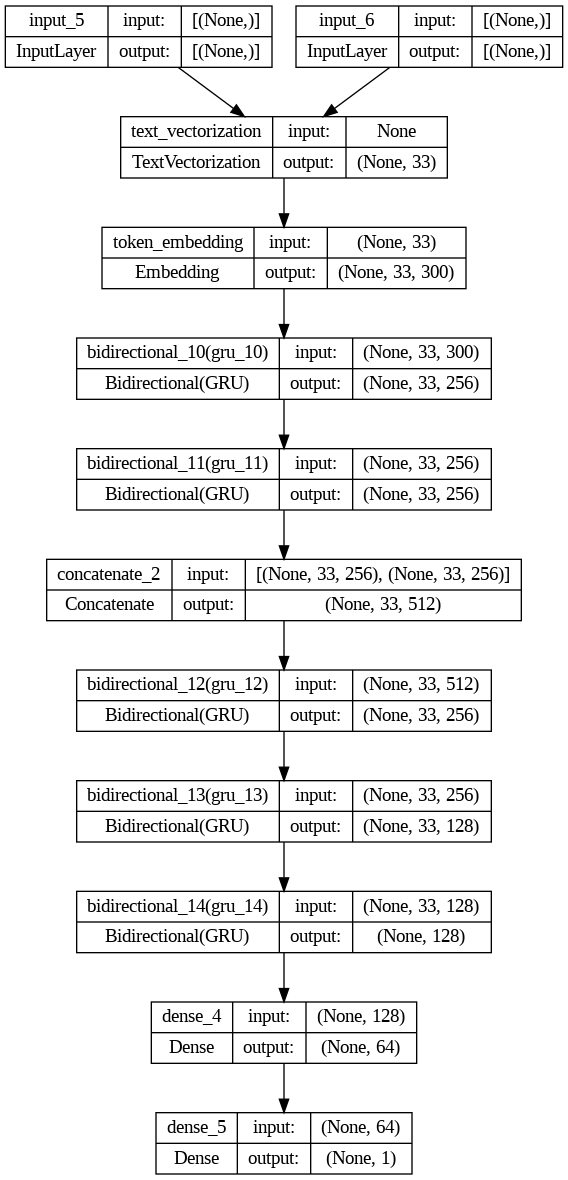

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model2,show_shapes=True)

In [ ]:
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=['accuracy'])

In [ ]:
history2=model2.fit(train_token_dataset,
                    epochs=10,
                    validation_data=val_token_dataset,
                    validation_steps=int(0.2*len(val_token_dataset)),
                    callbacks=[reduce_lr,early_stopping])

Epoch 1/10
10739/10739 [==============================] - 360s 31ms/step - loss: 0.5640 - accuracy: 0.7681 - val_loss: 0.5289 - val_accuracy: 0.8092 - lr: 0.0010
Epoch 2/10
10739/10739 [==============================] - 342s 32ms/step - loss: 0.5165 - accuracy: 0.8214 - val_loss: 0.5175 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 3/10
10739/10739 [==============================] - 336s 31ms/step - loss: 0.4892 - accuracy: 0.8516 - val_loss: 0.5091 - val_accuracy: 0.8347 - lr: 0.0010
Epoch 4/10
10739/10739 [==============================] - 334s 31ms/step - loss: 0.4702 - accuracy: 0.8716 - val_loss: 0.5022 - val_accuracy: 0.8371 - lr: 0.0010
Epoch 5/10
10739/10739 [==============================] - 330s 31ms/step - loss: 0.4554 - accuracy: 0.8866 - val_loss: 0.5056 - val_accuracy: 0.8385 - lr: 0.0010
Epoch 6/10
10739/10739 [==============================] - ETA: 0s - loss: 0.4461 - accuracy: 0.8958
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
10739/10739 [

In [ ]:
model2.evaluate(val_token_dataset)

948/948 [==============================] - 14s 14ms/step - loss: 0.5246 - accuracy: 0.8445


[0.5246480107307434, 0.844502329826355]

In [ ]:
model2.evaluate(test_token_dataset)

948/948 [==============================] - 13s 14ms/step - loss: 0.5222 - accuracy: 0.8458


[0.5221778154373169, 0.8457555770874023]

### Fine Tuning DistilBERT: Transformers

In [37]:
!pip install transformers[torch] datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00


In [38]:
!pip install torchinfo

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix

#### Loading dataset using datasets lib

In [40]:
train_df = xtrain.copy()
val_df = xval.copy()
test_df = xtest.copy()

train_df['label'] = ytrain
val_df['label'] = yval
test_df['label'] = ytest

train_df['question1']= train_df['question1'].astype('str').apply(lambda x:x if len(x)>5 else np.nan)
train_df['question2']= train_df['question2'].astype('str').apply(lambda x:x if len(x)>5 else np.nan)

val_df['question1']= val_df['question1'].astype('str').apply(lambda x:x if len(x)>5 else np.nan)
val_df['question2']= val_df['question2'].astype('str').apply(lambda x:x if len(x)>5 else np.nan)

test_df['question1']= test_df['question1'].astype('str').apply(lambda x:x if len(x)>5 else np.nan)
test_df['question2']= test_df['question2'].astype('str').apply(lambda x:x if len(x)>5 else np.nan)

train_df.dropna(inplace=True,axis=0)
val_df.dropna(inplace=True,axis=0)
test_df.dropna(inplace=True,axis=0)
train_df.drop(['charq1','charq2'],axis=1).to_csv("train.csv",index=False)
val_df.drop(['charq1','charq2'],axis=1).to_csv("val.csv",index=False)
test_df.drop(['charq1','charq2'],axis=1).to_csv("test.csv",index=False)


In [41]:
from datasets import load_dataset

dataset = load_dataset('csv',data_files={'train':'train.csv','val':'val.csv','test':'test.csv'})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [42]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label'],
        num_rows: 343567
    })
    val: Dataset({
        features: ['question1', 'question2', 'label'],
        num_rows: 30316
    })
    test: Dataset({
        features: ['question1', 'question2', 'label'],
        num_rows: 30317
    })
})

#### Loading tokenizer

In [43]:
checkpoint='distilbert-base-cased'

In [44]:
from transformers import AutoTokenizer

In [45]:
tokenizer=AutoTokenizer.from_pretrained(checkpoint)

In [46]:
def tokenize_fn(batch):
  return tokenizer(batch['question1'],batch['question2'])

In [47]:
tokenized_datasets=dataset.map(tokenize_fn,batched=True)

Map:   0%|          | 0/343567 [00:00<?, ? examples/s]

Map:   0%|          | 0/30316 [00:00<?, ? examples/s]

Map:   0%|          | 0/30317 [00:00<?, ? examples/s]

#### Specifying TrainingArgs and Config

In [48]:
from transformers import TrainingArguments

In [49]:
# can specify learning rate and increase num epochs
training_args=TrainingArguments(
    output_dir='training_dir',
    evaluation_strategy='epoch',
    #learning_rate = 5e-5,
    save_strategy = 'epoch',
    num_train_epochs = 2,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64
)


#### Loading metrics

In [50]:
import numpy as np
from sklearn.metrics import accuracy_score,f1_score

In [51]:
def compute_metrics(logits_and_labels):
  logits,labels=logits_and_labels
  predictions=np.argmax(logits,axis=-1)
  acc=accuracy_score(labels,predictions)
  f1=f1_score(labels,predictions,average='macro'),
  return {'f1':f1,'acc':acc}


#### Loading model

In [52]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [53]:
model= AutoModelForSequenceClassification.from_pretrained(checkpoint)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           1,538
├─Dropout: 1-4                                          --
Total params: 65,783,042
Trainable params: 65,783,042
Non-trainable params: 0

#### Creating a trainer and training

In [55]:
trainer=Trainer(model,
                training_args,
                train_dataset=tokenized_datasets['train'],
                eval_dataset=tokenized_datasets['val'],
                tokenizer=tokenizer,
                compute_metrics=compute_metrics)

In [56]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1,Acc
1,0.309200,0.292581,"(0.8626980834922824,)",0.869739
2,0.207200,0.270051,"(0.8799452589486733,)",0.887518


Trainer is attempting to log a value of "(0.8626980834922824,)" of type <class 'tuple'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "(0.8799452589486733,)" of type <class 'tuple'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=10738, training_loss=0.28151702383506405, metrics={'train_runtime': 3772.0387, 'train_samples_per_second': 182.165, 'train_steps_per_second': 2.847, 'total_flos': 1.2270889537431732e+16, 'train_loss': 0.28151702383506405, 'epoch': 2.0})

In [57]:
!ls training_dir

checkpoint-10738  checkpoint-5369  runs


In [58]:
trainer.save_model("my_saved_custom_model")

#### Evaluating on test set

In [59]:
predictions = trainer.predict(tokenized_datasets['test'])
predictions=np.argmax(predictions[0],axis=-1)

In [60]:
print("Accuracy: ",accuracy_score(dataset['test']['label'],predictions))
print("F1: ",f1_score(dataset['test']['label'],predictions,average='macro'))

Accuracy:  0.8885443810403404
F1:  0.8822185014818638


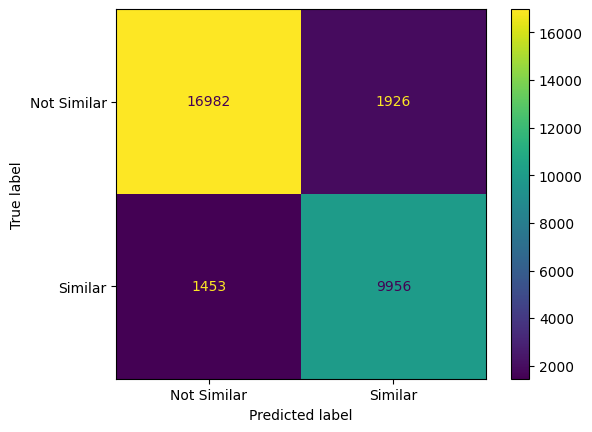

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay

cmp=ConfusionMatrixDisplay.from_predictions(dataset['test']['label'],predictions,display_labels=['Not Similar','Similar'])

### Model 3: Token-Char GRUs

#### Creating Dataset pipeline

In [ ]:
train_data=tf.data.Dataset.from_tensor_slices((xtrain['question1'].values,
                                               xtrain['question2'].values,
                                               xtrain['charq1'].values,
                                               xtrain['charq2'].values))
train_labels=tf.data.Dataset.from_tensor_slices(ytrain.apply(pd.to_numeric).values)
train_dataset=tf.data.Dataset.zip((train_data,train_labels))
train_dataset=train_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)



val_data=tf.data.Dataset.from_tensor_slices((xval['question1'].values,
                                               xval['question2'].values,
                                             xval['charq1'].values,
                                             xval['charq2'].values))
val_labels=tf.data.Dataset.from_tensor_slices(yval.apply(pd.to_numeric).values)
val_dataset=tf.data.Dataset.zip((val_data,val_labels))
val_dataset=val_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)



test_data=tf.data.Dataset.from_tensor_slices((xtest['question1'].values,
                                               xtest['question2'].values,
                                              xtest['charq1'].values,
                                              xtest['charq2'].values))
test_labels=tf.data.Dataset.from_tensor_slices(ytest.apply(pd.to_numeric).values)
test_dataset=tf.data.Dataset.zip((test_data,test_labels))
test_dataset=test_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

#### Model

In [ ]:
q1_token_inputs=tf.keras.layers.Input(shape=(),dtype=tf.string)
q1_preprocessor=text_vectorizer(q1_token_inputs)
q1_embed=text_embedding(q1_preprocessor)



q2_token_inputs=tf.keras.layers.Input(shape=(),dtype=tf.string)
q2_preprocessor=text_vectorizer(q2_token_inputs)
q2_embed=text_embedding(q2_preprocessor)


token_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))
token_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh',return_sequences=True))

q1_token_gru1=token_gru1(q1_embed)
q1_token_gru2=token_gru2(q1_token_gru1)

q2_token_gru1=token_gru1(q2_embed)
q2_token_gru2=token_gru2(q2_token_gru1)


q1_char_inputs=tf.keras.layers.Input(shape=(1,),dtype=tf.string)
q1_char_preprocessor=char_vectorizer(q1_char_inputs)
q1_char_embed=char_embedding(q1_char_preprocessor)



q2_char_inputs=tf.keras.layers.Input(shape=(1,),dtype=tf.string)
q2_char_preprocessor=char_vectorizer(q2_char_inputs)
q2_char_embed=char_embedding(q2_char_preprocessor)

char_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))
char_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh',return_sequences=True))

q1_char_gru1=char_gru1(q1_char_embed)
q1_char_gru2=char_gru2(q1_char_gru1)

q2_char_gru1=char_gru1(q2_char_embed)
q2_char_gru2=char_gru2(q2_char_gru1)

q1_q2_token_concat=tf.keras.layers.Concatenate()([q1_token_gru2,
                               q2_token_gru2])

combined_token_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))(q1_q2_token_concat)
combined_token_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh',return_sequences=True))(combined_token_gru1)
combined_token_gru3=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh'))(combined_token_gru2)

q1_q2_char_concat=tf.keras.layers.Concatenate()([q1_char_gru2,
                               q2_char_gru2])

combined_char_gru1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,activation='tanh',return_sequences=True))(q1_q2_char_concat)
combined_char_gru2=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh',return_sequences=True))(combined_char_gru1)
combined_char_gru3=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,activation='tanh'))(combined_char_gru2)


token_char_concat=tf.keras.layers.Concatenate()([combined_token_gru3,
                               combined_char_gru3])


combined_dense1=tf.keras.layers.Dense(64,activation='relu')(token_char_concat)
output=tf.keras.layers.Dense(1,activation='sigmoid')(combined_dense1)

model3=tf.keras.Model(inputs=[q1_token_inputs,q2_token_inputs,q1_char_inputs,q2_char_inputs],
                      outputs=output,
                      name='Model3')

In [ ]:
model3.summary()

Model: "Model3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 1)]          0           []                               
                                                                                             

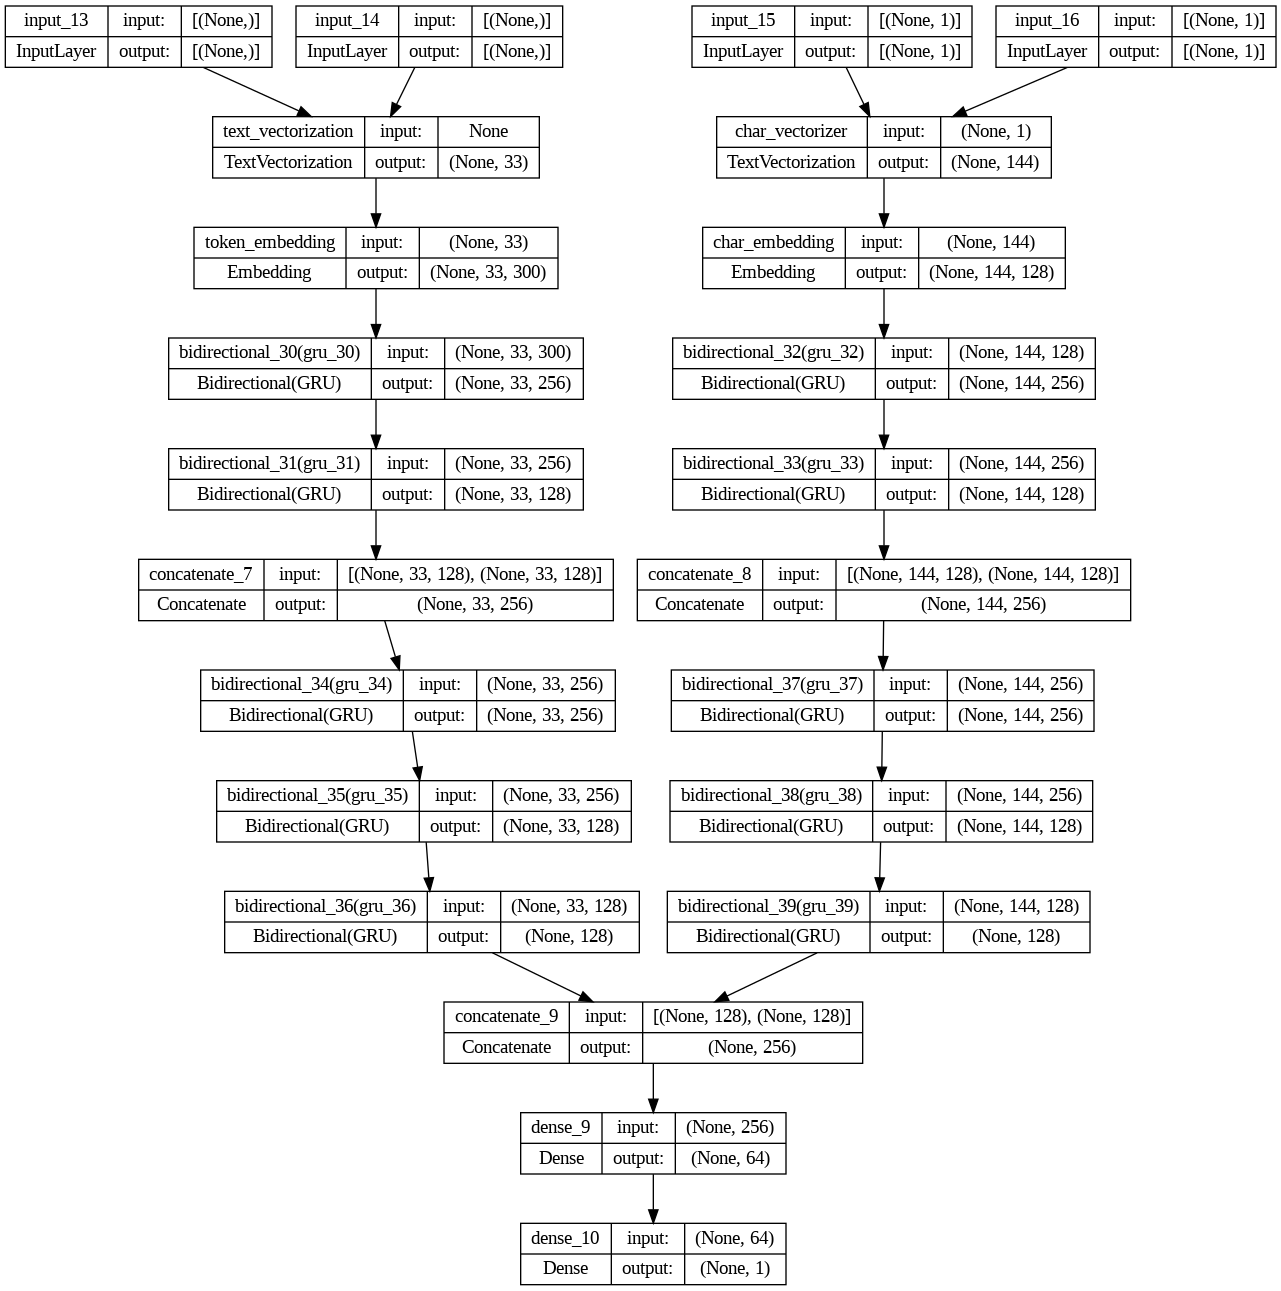

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model3,show_shapes=True)

In [ ]:
model3.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.Adam(lr=0.001),
               metrics=['accuracy'])

In [ ]:
history3=model3.fit(train_dataset,
                    epochs=15,
                    validation_data=val_dataset,
                    validation_steps=int(0.2*len(val_dataset)),
                    callbacks=[early_stopping,reduce_lr])

Epoch 1/15
10739/10739 [==============================] - 1688s 150ms/step - loss: 0.5615 - accuracy: 0.7701 - val_loss: 0.5283 - val_accuracy: 0.8057 - lr: 0.0010
Epoch 2/15
10739/10739 [==============================] - 1598s 149ms/step - loss: 0.5138 - accuracy: 0.8246 - val_loss: 0.5233 - val_accuracy: 0.8189 - lr: 0.0010
Epoch 3/15
10739/10739 [==============================] - 1571s 146ms/step - loss: 0.4874 - accuracy: 0.8541 - val_loss: 0.5122 - val_accuracy: 0.8304 - lr: 0.0010
Epoch 4/15
10739/10739 [==============================] - 1600s 149ms/step - loss: 0.4673 - accuracy: 0.8757 - val_loss: 0.5156 - val_accuracy: 0.8317 - lr: 0.0010
Epoch 5/15
10739/10739 [==============================] - ETA: 0s - loss: 0.4526 - accuracy: 0.8903
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
10739/10739 [==============================] - 1557s 145ms/step - loss: 0.4526 - accuracy: 0.8903 - val_loss: 0.5173 - val_accuracy: 0.8353 - lr: 0.0010
Epoch 6/15
  5

In [ ]:
model3.evaluate(val_dataset)

In [ ]:
model3.evaluate(test_dataset)

In [ ]:
asdasdasdsdasasdasadasdasdasdfsdfsdffdfdvdfscsddfvdfgdfdfvdfgfdgdfgdfgdfgdfgwhbdf
thhfgdfgdfsdfsdfsfsdsdfsdyttsdfsdfasdasdsadferdfvfdvfjhjhjhjhjh

In [ ]:
asdasd,asdas,hyyhijyuh,thth

In [ ]:
asdasd,thjmhjmjhjytttytrsadasdassdfsdfsd

In [ ]:
uygdfgdfgdfgdfgdfdf